# NEQR model (test)
### in this jupyter notebook, we will discover how to convert an image into quantum circuit using NEQR model.
Part1: Test the model with 2x2 image (resize the QOSF image into 2x2 image) \
Part2: Test the model with 4x4 image (resize the QOSF image into 4x4 image) \
Part3: Test the model with RGB 2x2 image (resize the QOSF image into RGB 2x2 image) \
Part4: Using the model on the QOSF image  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from qiskit import execute, transpile
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.providers.aer.backends import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import io
import imageio as iio
from neqr import NEQR
import QTeleport as qt

In [2]:
image_neqr = NEQR()
shots = 8192
backend = AerSimulator()

In [3]:
qosf = iio.imread('qosf.jpg')
qosf.shape

(24, 24, 3)

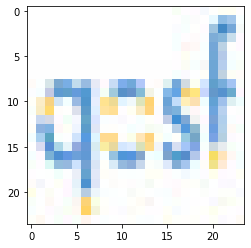

In [4]:
plt.imshow(qosf)
plt.show()

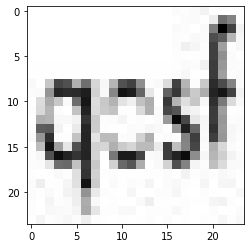

In [5]:
gray_qosf = rgb2gray(qosf)

plt.imshow(gray_qosf, cmap="gray")

plt.show()

In [6]:
gray_qosf.size

576

### Remark:
The image is blurred because the number of pixels is reduced to facilitate the conversion of the image into a quantum circuit using fewer Qbits in the circuit.

## Part1: Test the model with 2x2 image (resize the QOSF image into 2x2 image) 


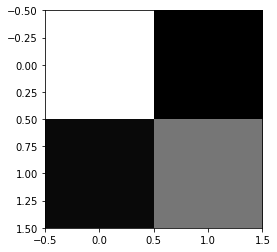

In [7]:
resized_gray_qosf = resize(gray_qosf, (2,2))
plt.imshow(resized_gray_qosf, cmap="gray")

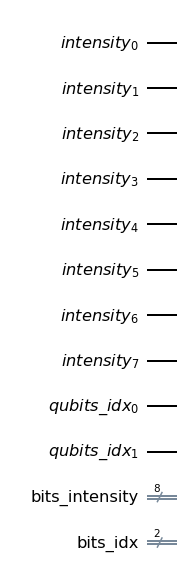

In [8]:
qubits_idx = QuantumRegister(size=2, name="qubits_idx")
intensity = QuantumRegister(size=8, name="intensity")
bits_idx = ClassicalRegister(size=2, name="bits_idx")
bits_intensity = ClassicalRegister(size=8, name="bits_intensity")

qc = QuantumCircuit(intensity, qubits_idx, bits_intensity, bits_idx)
qc.draw(output="mpl")

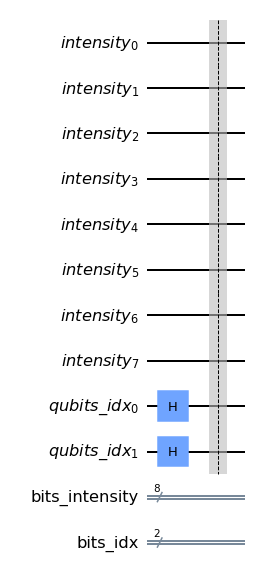

In [9]:
qc.h(qubit=qubits_idx)
qc.barrier()
qc.draw(output="mpl")

In [10]:
pixel_pos_intensity = []

for row in resized_gray_qosf:
    for item in row:
        pixel_pos_intensity.append(int(np.round(255*item)))
        
bin_list = [bin(num)[2:] for num in pixel_pos_intensity]

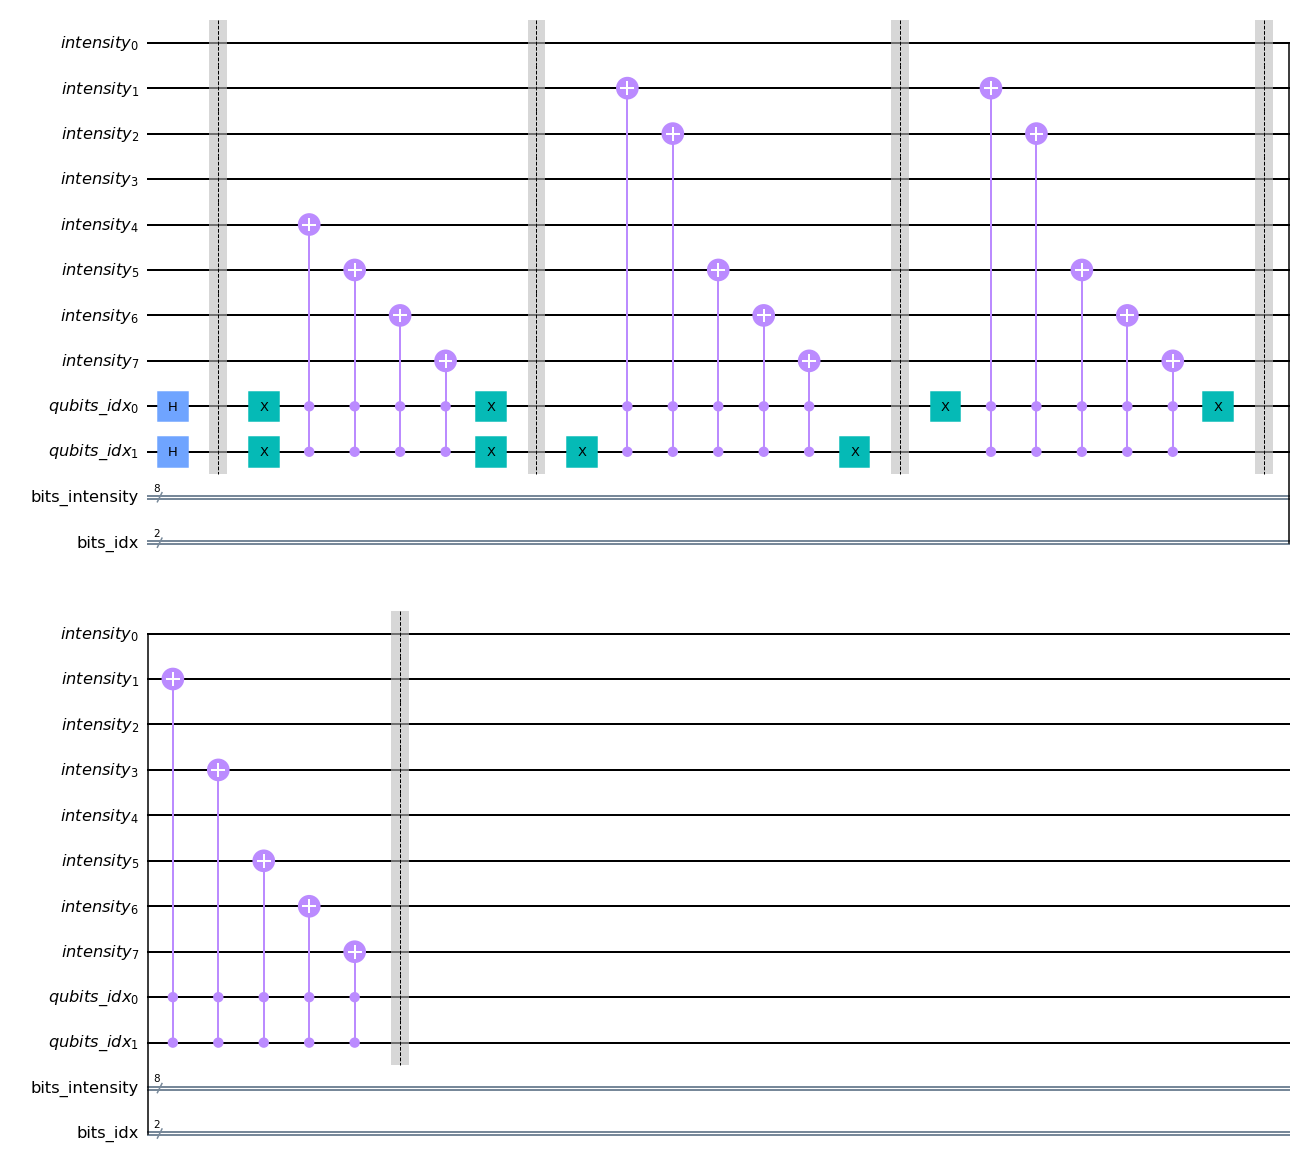

In [11]:
for idx, bnum in enumerate(bin_list):
    
    if idx == 0:
        qc.x(qubit=qubits_idx)
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx)
        qc.barrier()
    elif idx == 1:
        qc.x(qubit=qubits_idx[1])
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx[1])
        qc.barrier()
    elif idx == 2:
        qc.x(qubit=qubits_idx[0])
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx[0])
        qc.barrier()
    else:
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.barrier()
        
qc.draw(output="mpl")

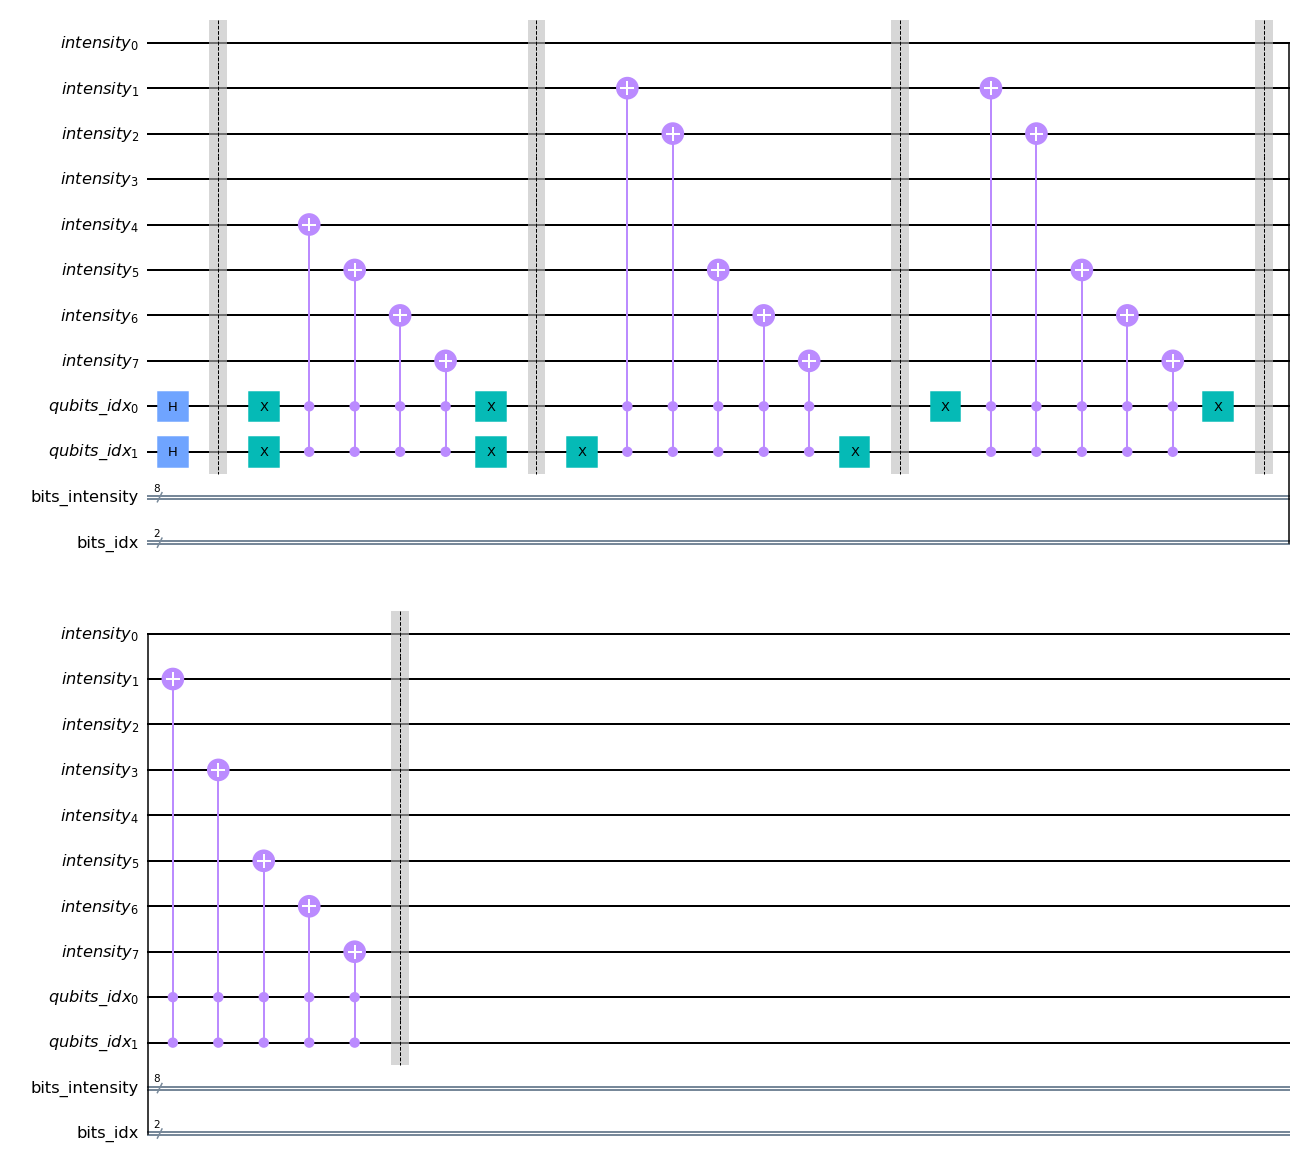

In [12]:
#qc.measure(qubit=intensity, cbit=bits_intensity)
#qc.barrier()
#qc.measure(qubit=qubits_idx, cbit=bits_idx)
qc.draw(output="mpl")

In [13]:
qc=qt.QTeleport(qc)

In [14]:
print("Circuit dimensions")
print(f"Number of qubits: {qc.qregs[0].size + qc.qregs[1].size}")
print(f"Circuit depth: {qc.depth()}")
print(f"Circuit size: {qc.size()}")
print(f"Circuit operations: {qc.count_ops()}")

Circuit dimensions


IndexError: list index out of range

In [ ]:
counts_total = execute(experiments=qc, backend=backend, shots=shots).result().get_counts()

print("NEQR inverse: from the Qcricuit to image")
im=image_neqr.reconstruct_image_from_neqr_result(counts_total, (2,2))
print(im)
plt.gray()
plt.imshow(im)
plt.show()

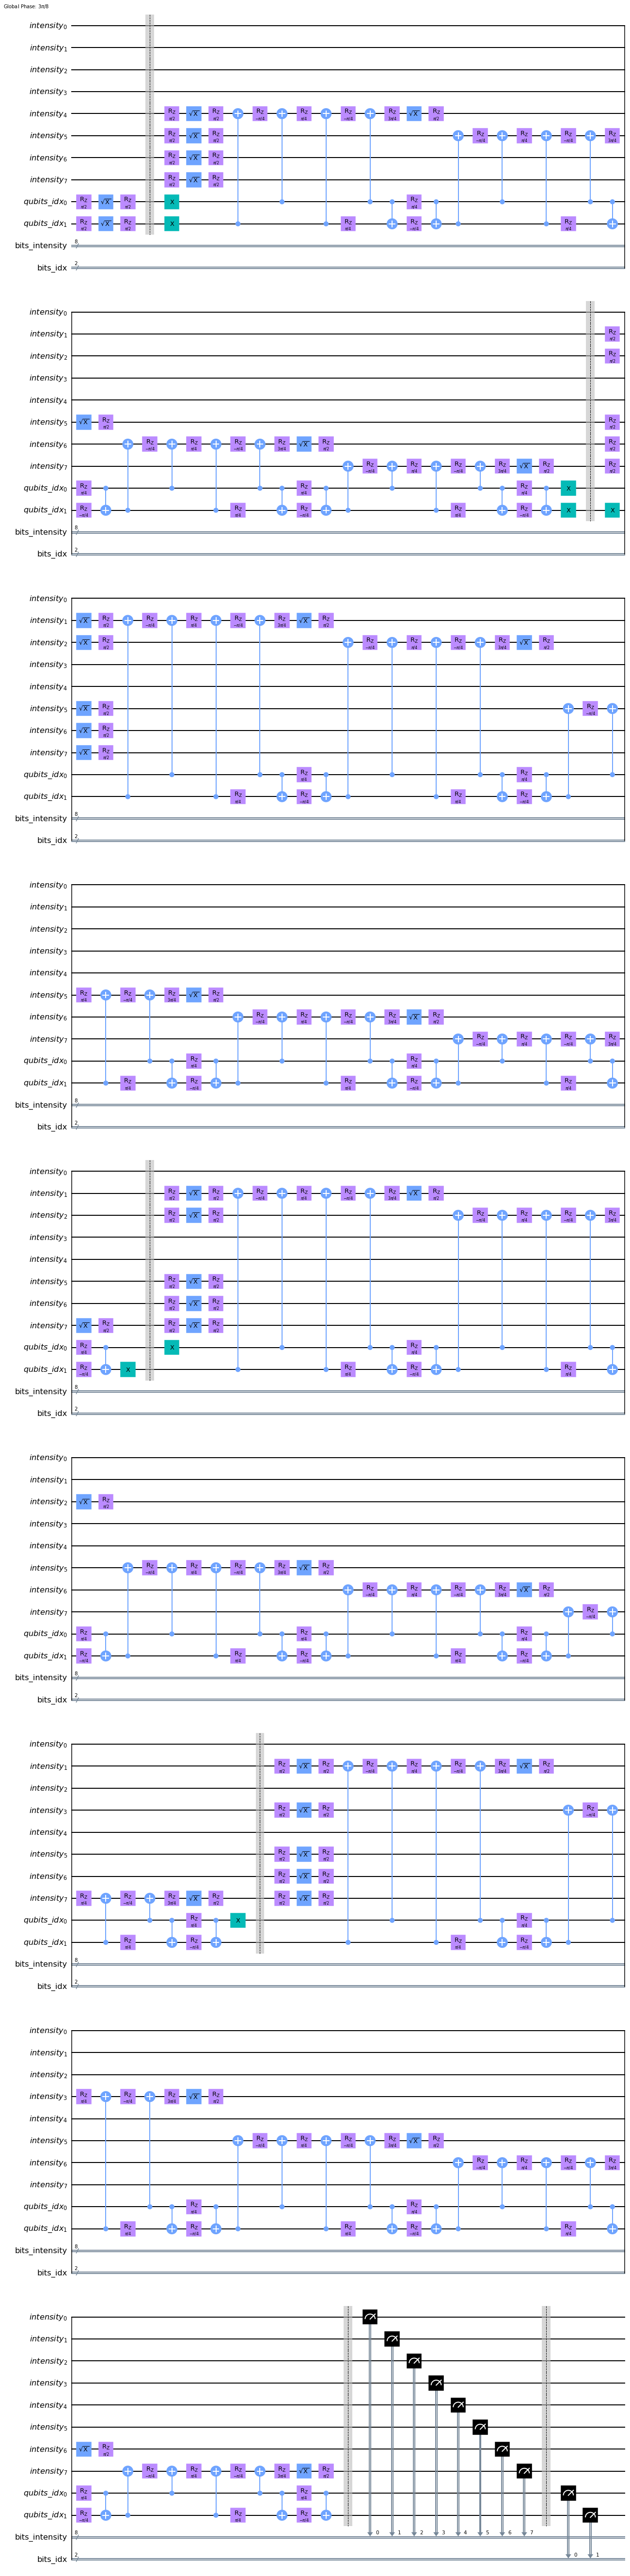

In [15]:
transpiled_qc = transpile(circuits=qc, basis_gates=["id", "x", "sx", "cx", "rz"])
transpiled_qc.draw(output="mpl")

In [16]:
print("Circuit dimensions")
print(f"Circuit depth: {transpiled_qc.depth()}")
print(f"Circuit size: {transpiled_qc.size()}")
print(f"Circuit operations: {transpiled_qc.count_ops()}")

Circuit dimensions
Circuit depth: 210
Circuit size: 366
Circuit operations: OrderedDict([('rz', 194), ('cx', 114), ('sx', 40), ('measure', 10), ('x', 8), ('barrier', 6)])


In [17]:
qcircuit = image_neqr.image_quantum_circuit(image=resized_gray_qosf, measurements=True)

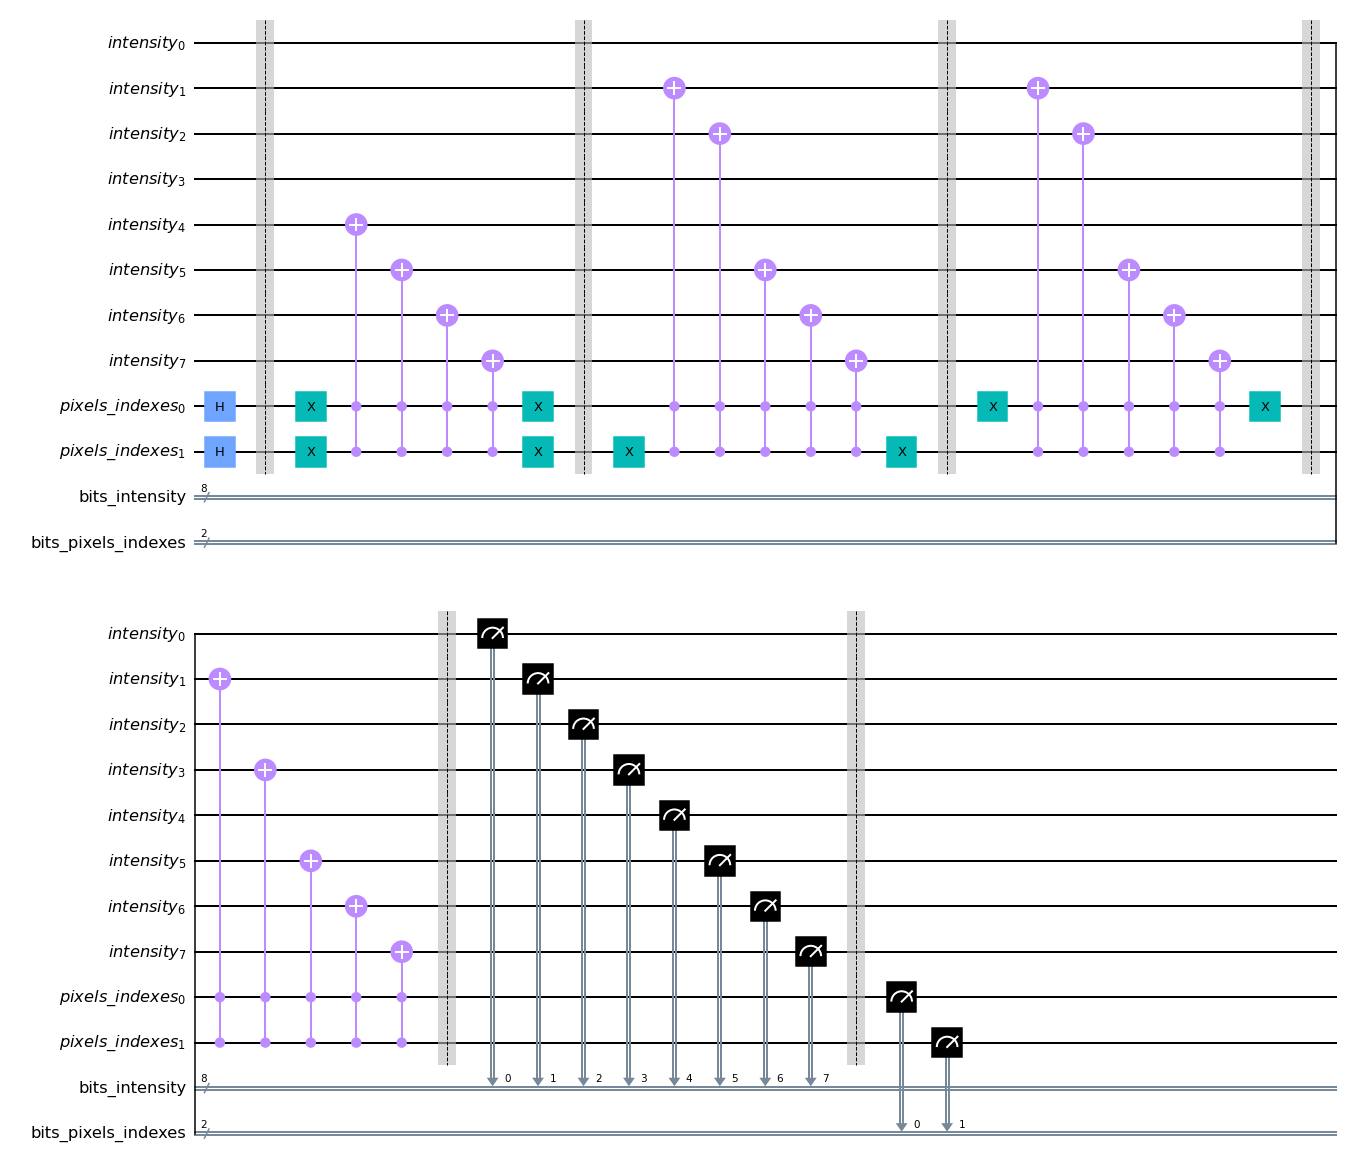

In [18]:
qcircuit.draw(output="mpl")

In [19]:
print("Circuit dimensions")
print(f"Number of qubits: {qcircuit.qregs[0].size + qcircuit.qregs[1].size}")
print(f"Circuit depth: {qcircuit.depth()}")
print(f"Circuit size: {qcircuit.size()}")
print(f"Circuit operations: {qcircuit.count_ops()}")

Circuit dimensions
Number of qubits: 10
Circuit depth: 28
Circuit size: 39
Circuit operations: OrderedDict([('ccx', 19), ('measure', 10), ('x', 8), ('barrier', 6), ('h', 2)])


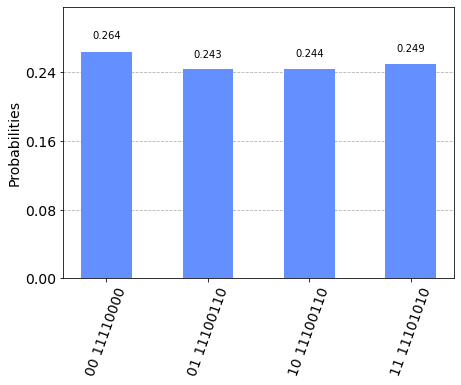

In [20]:
counts = execute(experiments=qcircuit, backend=backend, shots=shots).result().get_counts()
plot_histogram(counts)

## Part2: Test the model with 4x4 image (resize the QOSF image into 4x4 image) 


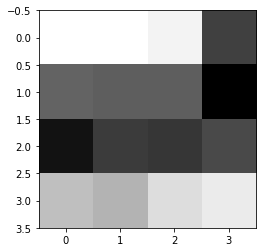

In [21]:
resized_gray_qosf_33 = resize(gray_qosf, (4,4))
plt.imshow(resized_gray_qosf_33, cmap="gray")

In [22]:
qcircuit = image_neqr.image_quantum_circuit(image=resized_gray_qosf_33, measurements=True)

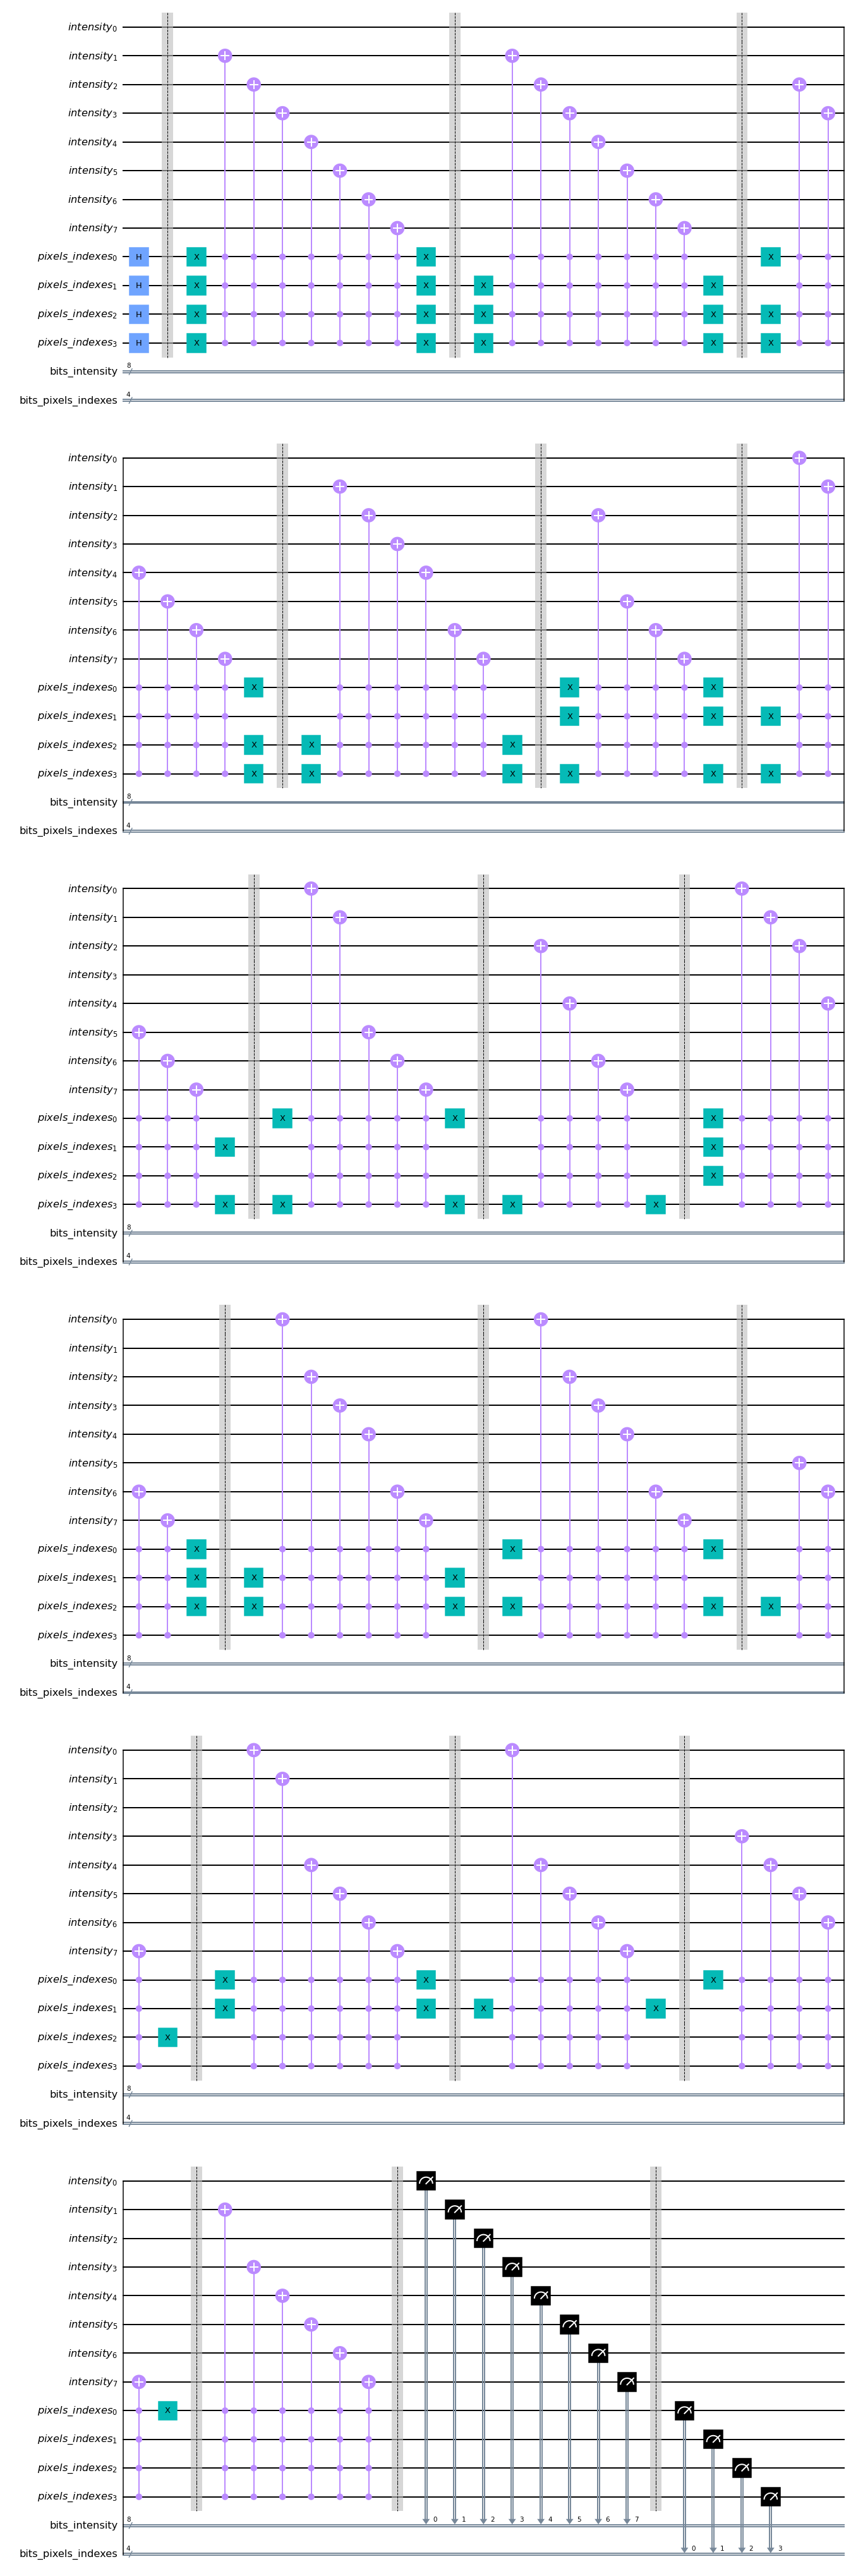

In [23]:
qcircuit.draw(output="mpl")

In [24]:
print("Circuit dimensions")
print(f"Number of qubits: {qcircuit.qregs[0].size + qcircuit.qregs[1].size}")

print(f"Circuit depth: {qcircuit.depth()}")
print(f"Circuit size: {qcircuit.size()}")
print(f"Circuit operations: {qcircuit.count_ops()}")

Circuit dimensions
Number of qubits: 12
Circuit depth: 120
Circuit size: 167
Circuit operations: OrderedDict([('mcx', 87), ('x', 64), ('barrier', 18), ('measure', 12), ('h', 4)])


NEQR inverse: from the Qcricuit to image
[[0.99607843 0.99607843 0.98823529 0.87058824]
 [0.89411765 0.89019608 0.89019608 0.83137255]
 [0.84313725 0.86666667 0.86666667 0.87843137]
 [0.95294118 0.94509804 0.97254902 0.98039216]]


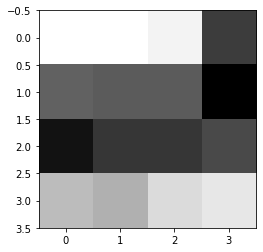

In [25]:
counts = execute(experiments=qcircuit, backend=backend, shots=shots).result().get_counts()

print("NEQR inverse: from the Qcricuit to image")
im=image_neqr.reconstruct_image_from_neqr_result(counts, (4,4))
print(im)
plt.gray()
plt.imshow(im)
plt.show()

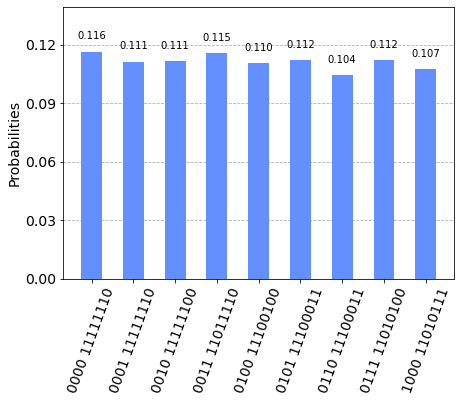

In [26]:
keys_list = [key for key, _ in sorted(counts.items())][:9]
processed_counts = {key: counts[key] for key in keys_list}
plot_histogram(processed_counts)

## Part3: Test the model with RGB 2x2 image (resize the QOSF image into RGB 2x2 image) 


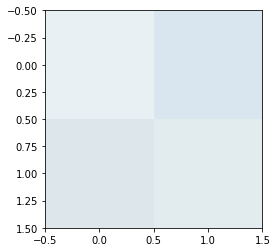

In [27]:
resized_rgb_qosf = resize(qosf, (2,2))
plt.imshow(resized_rgb_qosf)

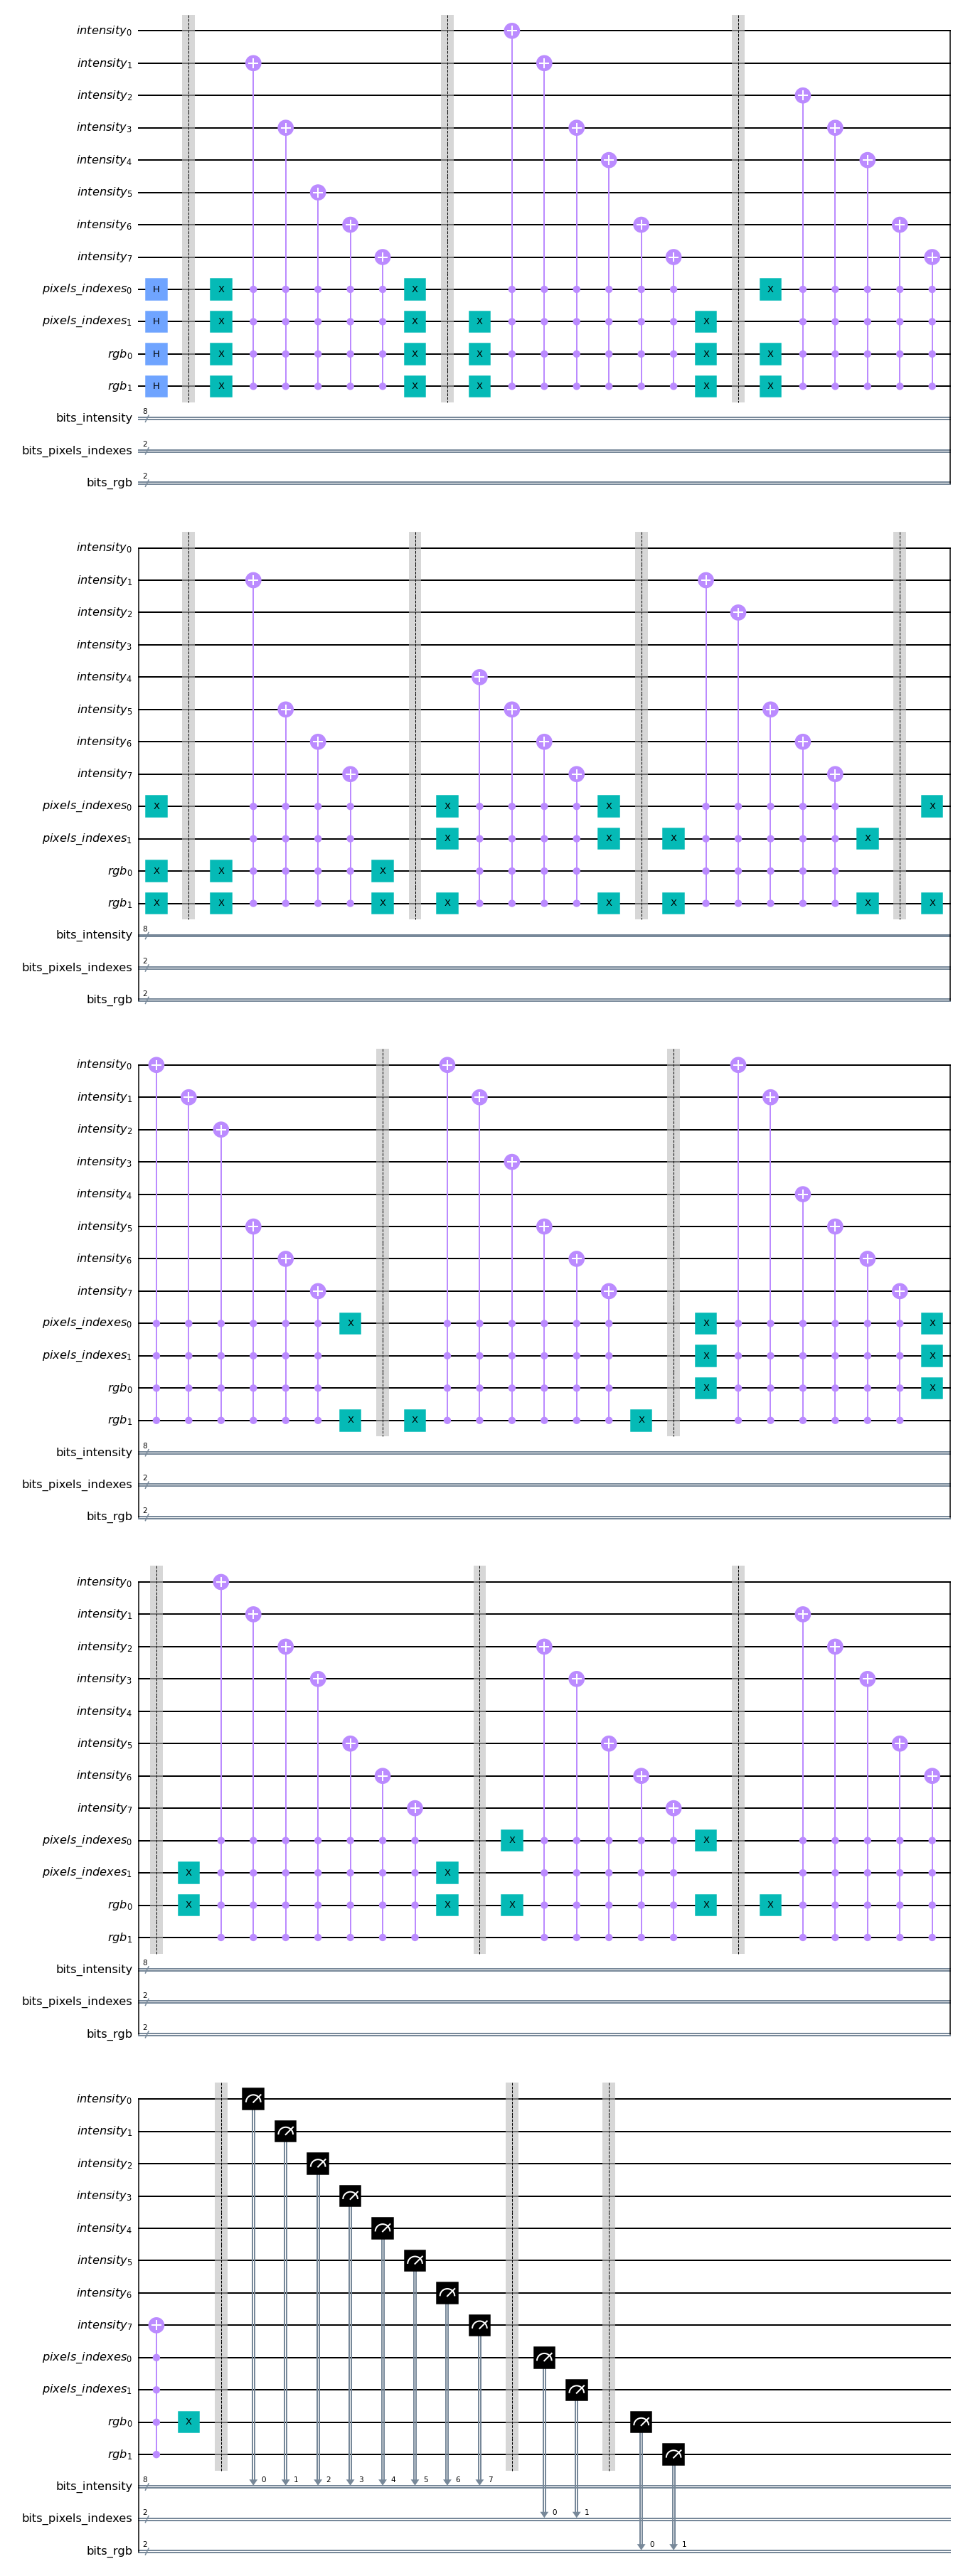

In [28]:
qc = image_neqr.image_quantum_circuit(image=resized_rgb_qosf, measurements=True)
qc.draw(output="mpl")

In [29]:
print("Circuit dimensions")
print(f"Number of qubits: {qc.qregs[0].size + qc.qregs[1].size}")
print(f"Circuit depth: {qc.depth()}")
print(f"Circuit size: {qc.size()}")
print(f"Circuit operations: {qc.count_ops()}")

Circuit dimensions
Number of qubits: 10
Circuit depth: 93
Circuit size: 137
Circuit operations: OrderedDict([('mcx', 65), ('x', 56), ('barrier', 15), ('measure', 12), ('h', 4)])


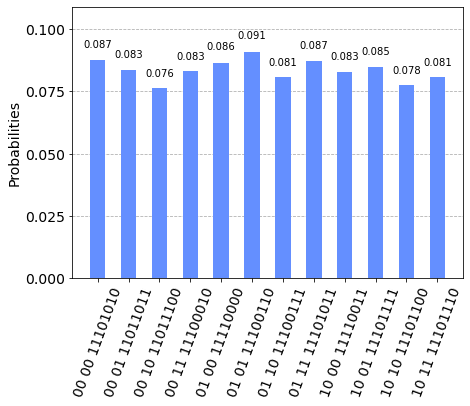

In [30]:
counts = execute(experiments=qc, backend=backend, shots=shots).result().get_counts()
keys_list = [key for key, _ in sorted(counts.items())][:12]
processed_counts = {key: counts[key] for key in keys_list}
plot_histogram(processed_counts)

## Part4: Using the model on the QOSF image  

In [31]:
qc_gray = QuantumCircuit(intensity, qubits_idx, bits_intensity, bits_idx)

qc_gray= image_neqr.image_quantum_circuit(image=gray_qosf, measurements=True)

print("Circuit dimensions")
print(f"Number of qubits: {qc_gray.qregs[0].size + qc_gray.qregs[1].size}")
print(f"Circuit depth: {qc_gray.depth()}")
print(f"Circuit size: {qc_gray.size()}")
print(f"Circuit operations: {qc_gray.count_ops()}")

Circuit dimensions
Number of qubits: 18
Circuit depth: 4796
Circuit size: 10069
Circuit operations: OrderedDict([('x', 6400), ('mcx_gray', 3641), ('barrier', 578), ('measure', 18), ('h', 10)])


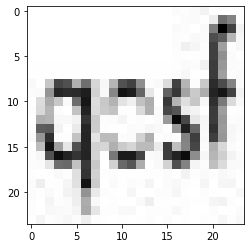

In [32]:
plt.imshow(gray_qosf, cmap="gray")
plt.show()

NEQR inverse: from the Qcricuit to image


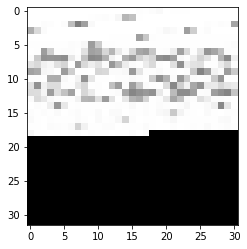

In [39]:
counts_total = execute(experiments=qc_gray, backend=backend, shots=shots).result().get_counts()

print("NEQR inverse: from the Qcricuit to image")
im=image_neqr.reconstruct_image_from_neqr_result(counts_total, (32,31))
plt.gray()
plt.imshow(im)
plt.show()

### Remark:


# References
[1] [Qiskit Textbook](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html#Novel-Enhanced-Quantum-Representation-(NEQR)-for-Digital-Images)\
[2] [Anand, Alok, et al. "Quantum Image Processing." arXiv preprint arXiv:2203.01831 (2022).](https://arxiv.org/pdf/2203.01831.pdf)